<a href="https://colab.research.google.com/github/hallmx/DL_medical_imaging_cle-ai/blob/master/HAM10000_skin_lesion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This notebook is designed to be run as a Kaggle kernal*

# HAM10000 Skin Lesion Classification

Diagnosing skin lesions from dermatoscopic images using deep learning.

**Purpose**

Investigate the potential use of a DNN in classifying skin lesions from dermatoscopic images. Much research has been published on skin lesion classification using the HAM10000 dataset. Most have focused on the accuracy of models in correctly classifying skin lesions. Here we construct a state of thre art model for skin lesion classification in terms of accuracy metrics but go on to investigte its clinical usefulness. 

**Data**

HAM10000 ("Human Against Machine 10000 images"), a dataset of 10015 dermatoscopic images of 7 classes of skin lesion downloaded from kaggle at https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000.

Images include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

**Methodology**

A test dataset was constructed of unique images and with any duplicate images from the same lesion being dropped from the training set. Upsamping using KeraDataGenerator was used to create over 8000 new augmented images from original images of underrepresented classes (all classes except melanocytic nevi). The balnaced dataset was used to train a densenet121 pretrained model using transfer learning techniques from the Fastai2 deep learning library. Mixup data augmentation (https://dev.fast.ai/callback.mixup) was used. 

The model was trained for 20 epochs total with progressive resizing of images from 96x96px to 396x396px between each 5 epochs of training. The pretrained layers of the model were then unfrozen and trined with full size images for a further 5 epochs. An accuracy of > 90% was reported on the validation set.


**Results**

Our model accuracy compares favourably with published results, e.g., https://www.biorxiv.org/content/10.1101/860700v2.full. 

Evaluation on the test set of 1448 images gave a macro precision of 0.811, recall	0.686	and F1 score 0.724. Macro values were used as these more evenly represent unbalanced classes in the result. These are also comparable with published results using this dataset.

Examination of the confusion matrix, however, indicates considerable variation in results for the individual classes. While some classes, such as melanocytic nevi have false positive and false negative rates of 0.1 and 0.05 resectively, melanoma has a false positive rate 0.25 and false negative rate 0.64. Thus, despite its high accuracy, this model would miss over half of malignant melanomas, the most aggressive and deadly form of skin cancer, making it clinically unusable. 


**Suggested next steps**

The performance of our model to be limited by small and imbalanced nature of the HAM10000 dataset. In addition, its selectively poorer performance distinguishing malignant melanoma from other skin lesions may be due to the simularity in appearance of certain, particularly early stage, melanoma to other benign skin lesions. Thus a certain proportion of melanoma may be esentially indistinguishable from benign lesions using visual data alone and diagnosis requires other means, for example a clinical history to ascertain change over time or more likely skin biopsy. 

Researchers using a dataset of 130,000 photographs and dermatoscopic images of over 100 types of skin lesions have successfully classified lesions into benign vs malignant with an AUC-ROC of 91% (comparable if not better than specialist dermatologists) supporting the view that more data will improve DNN performance in this task. However, even this level of performance is unlikely to be sufficient to completely replace the role of dermatologist and skin biopsy in melanoma diagnosis any time yet.

## Notebook setup

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
pip install fastai2            # https://dev.fast.ai/

## Import libraries

In [0]:
# General
import os, pickle
from pathlib import Path
from tqdm import tqdm

# Data manipulation
import pandas as pd
import numpy as np
from random import sample, shuffle, randint
from sklearn import metrics, model_selection
from math import ceil

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Image manipulation
import PIL, cv2
from skimage.io import imread, imshow

# Visualizations
import matplotlib as plt
import matplotlib.patches as patches
import seaborn as sns

# Matplotlib options
plt.rcParams['font.size']=14

# DL libraries
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from torch import torch
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

Using TensorFlow backend.


In [0]:
print("GPU: ", torch.cuda.is_available())
print("python PIL version - ", PIL.PILLOW_VERSION)

GPU:  True
python PIL version -  5.4.1


## Define Paths

In [0]:
data_path = Path("../input/skin-cancer-mnist-ham10000")
print(os.listdir(data_path))

['ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_28_28_L.csv', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv']


## Get data

In [0]:
csv_path = data_path / 'HAM10000_metadata.csv'
df_data=pd.read_csv(csv_path).set_index('image_id')
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


## Utils

In [0]:
def bar_plt(y, x, title):
    sns.barplot(y=y, x=x, palette="dark")
    plt.xticks(rotation=60, fontsize=11)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize=14, pad=20)

In [0]:
def show_examples(df, col, n_samples = 5):
    "Show `n_samples` of each type of value in `col` of dataframe `df`"
    groups = df.sort_values([col]).groupby(col)
    n_rows = len(groups)
    fig, m_axs = plt.subplots(n_rows, n_samples, figsize = (3*n_samples, 2*n_rows))
    for n_axs, (type_name, type_rows) in zip(m_axs,groups):
        n_axs[0].set_title(type_name)
        for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples).iterrows()):
            c_ax.imshow(imread(c_row['path']))
            c_ax.axis('off')

## EDA

In [0]:
# Categories of the diferent diseases (thanks to kaggle.com/ingbiodanielh/skin-cancer-classification-with-resnet-50-fastai)
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df_data.dx=df_data.dx.astype('category',copy=True)
df_data['label']=df_data.dx.cat.codes # Convert the labels to numbers
df_data['lesion_type']= df_data.dx.map(lesion_type_dict)
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis


In [0]:
# for some reason the images are spread over two folders, HAM10000_images_part_1 and ...part_2
# add a column to the df with the path to the correct folders

# {filename : path} for all files in both image folders
imageid_path_dict = {str(x).split('/')[-1][:-4]: str(x) for x in list(data_path.glob('*/*.jpg'))}

# use {filename: path} dict to select items from the correct folders
df_data['path'] = [Path(data_path/imageid_path_dict[fn].split('/')[3]/f'{fn}.jpg') for fn in df_data.index.values]

In [0]:
# create key relating label to lesion_type
label_list = df_data['label'].value_counts().keys().tolist()
lesion_list = df_data['lesion_type'].value_counts().keys().tolist()
label_to_lesion = dict(zip(label_list, lesion_list))
label_to_lesion

{5: 'Melanocytic nevi',
 4: 'Melanoma',
 2: 'Benign keratosis ',
 1: 'Basal cell carcinoma',
 0: 'Actinic keratoses',
 6: 'Vascular lesions',
 3: 'Dermatofibroma'}

In [0]:
# take a quick look at the sizes of our images -> all 450x600!
img_sizes = set()
for row in df_data.itertuples():
    img = load_img(row.path)
    img_sizes.add(img.shape)

print(f'Image sizes: {img_sizes}')

Image sizes: {(450, 600)}


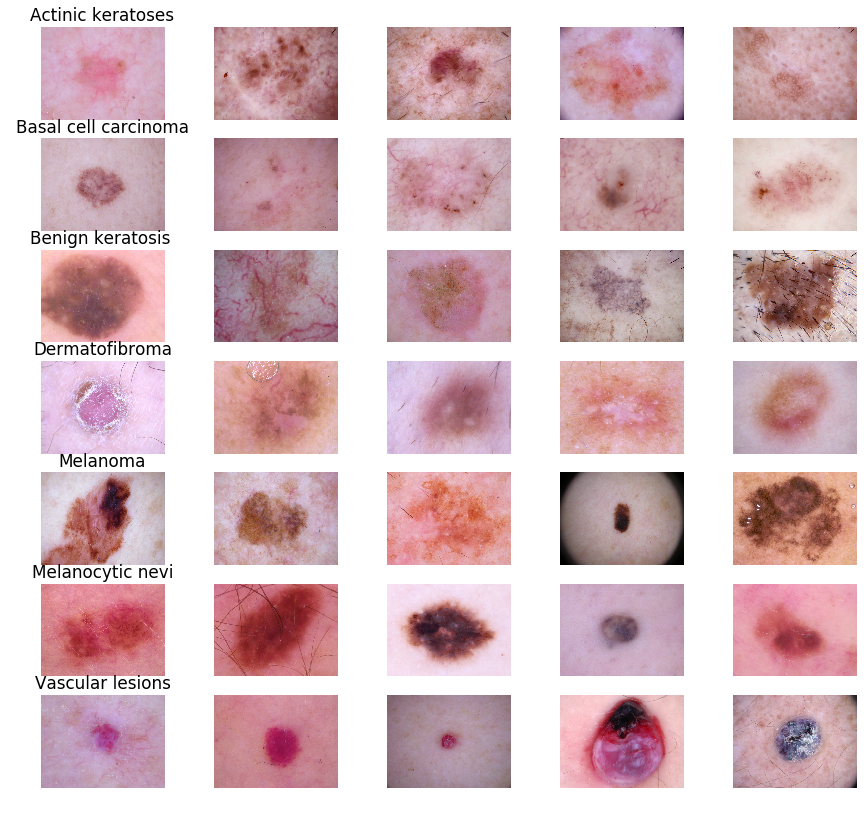

In [0]:
# some examples of each lesion
show_examples(df_data, 'lesion_type')

The csv file contains some additional data about the lesion and patients. Lest briefly examne it.

In [0]:
df_data.iloc[0]

lesion_id                                                                       HAM_0000118
dx                                                                                      bkl
dx_type                                                                               histo
age                                                                                      80
sex                                                                                    male
localization                                                                          scalp
label                                                                                     2
lesion_type                                                               Benign keratosis 
path            ../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg
Name: ISIC_0027419, dtype: object

Looks like we've got the age, sex and body location of the lesion.
lets have a look at those. But first check for missing data.

In [0]:
# we have some missing patient ages, which we can probably ignore.
pd.isnull(df_data).sum()

lesion_id        0
dx               0
dx_type          0
age             57
sex              0
localization     0
label            0
lesion_type      0
path             0
dtype: int64

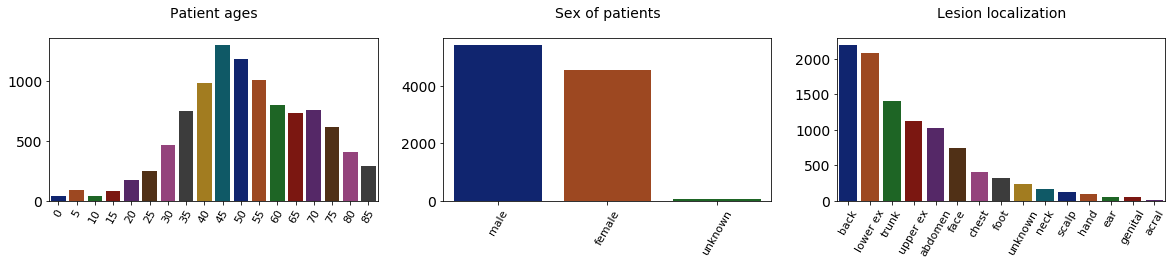

In [0]:
# plot histogram of patient ages
fig, axes = plt.subplots(1, 3, figsize=(20, 3))
plt.subplot(1, 3, 1)
data = df_data['age'].value_counts()
bar_plt(data.tolist(), [int(x) for x in data.keys().tolist()], title='Patient ages')

# plot bar chart of patients sex
plt.subplot(1, 3, 2)
data = df_data['sex'].value_counts()
bar_plt(data.tolist(), data.keys().tolist(), title='Sex of patients')

# plot barchart of localization of lesion on the body
plt.subplot(1, 3, 3)
data = df_data['localization'].value_counts()
bar_plt(data.tolist(), [x[:8] for x in data.keys().tolist()], title='Lesion localization')

## Data processing

Split out a labelled test set (df_test). 

When we check the lesion_id column we find that a lot of lesions have two or more different images associated with them. This is fine for training (where it acts as a form of data augmentation), but may falsify our validation and/or test results if images from the same lesion are in both the training AND validation/test sets.

In [0]:
# get number of non-unique lesion_id's
def check_duplicates(df, col):
    unique_list = df.lesion_id.unique().tolist()
    num_duplicates = len(df) - len(unique_list)
    return num_duplicates

num_duplicates = check_duplicates(df_data, 'lesion_id')
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_data)}')

Duplicate lesion_ids: 2545 out of 10015


In [0]:
test_set_fraction = 0.15

# randomly select the test set
df_train, df_test = model_selection.train_test_split(df_data, test_size=test_set_fraction)

# remove any duplicate images from the test set and check
df_test = df_test.drop_duplicates(subset='lesion_id', keep="first")
num_duplicates = check_duplicates(df_test, 'lesion_id')
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_test)}')

# remove any lesions from the train set that are also in the test set
df_train = df_train[~df_train.lesion_id.isin(df_test.lesion_id)]

# finally check test and train dfs have no shared `lesion_ids` or `image_ids`
import collections
check_lesion_ids = df_test['lesion_id'].isin(df_train['lesion_id']).value_counts()    
check_image_ids = collections.Counter(df_test.index.isin(df_train.index))
print(f'Test/train overlap? lesion_id: {int(check_lesion_ids) != len(df_test)}, image_id: {check_image_ids[0] != len(df_test)}')



Duplicate lesion_ids: 0 out of 1448
Test/train overlap? lesion_id: False, image_id: False


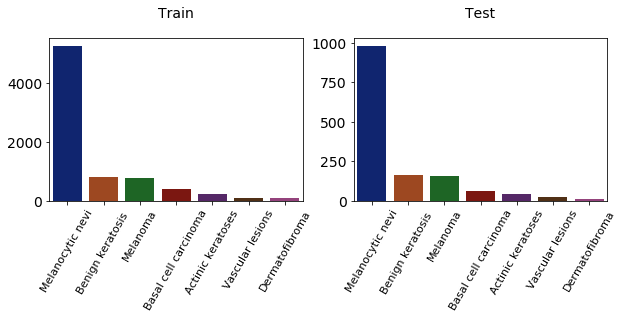

In [0]:
# Check the balance of the train and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for i, (df, title) in enumerate([(df_train, 'Train'), (df_test, 'Test')]):
    plt.subplot(1,2,i+1)
    data = df['lesion_type'].value_counts()
    bar_plt(data.tolist(), data.keys().tolist(), title=title)

## Prepare the dataset

### Split into train and validation sets

In [0]:
val_set_fraction = 0.15
df_train_idx = df_train.reset_index().copy()
df_trn, df_val = model_selection.train_test_split(df_train_idx, test_size=test_set_fraction, random_state=142)

del df_train_idx

In [0]:
df_trn.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path
2288,ISIC_0026384,HAM_0005127,nv,histo,55.0,female,chest,5,Melanocytic nevi,../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026384.jpg
6356,ISIC_0028436,HAM_0005127,nv,histo,55.0,female,chest,5,Melanocytic nevi,../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028436.jpg
144,ISIC_0028707,HAM_0000920,bkl,histo,60.0,male,upper extremity,2,Benign keratosis,../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028707.jpg
3474,ISIC_0028953,HAM_0000660,nv,follow_up,40.0,male,abdomen,5,Melanocytic nevi,../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028953.jpg
4050,ISIC_0027680,HAM_0004677,bkl,histo,80.0,male,back,2,Benign keratosis,../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027680.jpg


### Boost under-represented classes with selective augmentation.

Up-sample the underepresented lesion types by selective image augmentation. We use Keras ImageDataGenerator to create a series of new augmneted images based on the original image and save these to disk. WE then crate a new dataframe from these image paths and id information and merge it with the existing dataframe to be passed to the DataSet. Thank you to https://www.kaggle.com/jvikoren/fastai-mobilenet-90-acc for the code this section is based on.

In [0]:
# calculate an augmentation  multiplier for each class
counts = df_trn['label'].value_counts()
aug_mults = [(max(counts)/3)//counts[i] for i, c in enumerate(counts)]
aug_mults.sort()
aug_dict = dict(zip(counts.keys(), aug_mults))
aug_dict

{5: 0.0, 2: 2.0, 4: 2.0, 1: 4.0, 0: 7.0, 6: 16.0, 3: 19.0}

In [0]:
# add the multiplier to the training dataframe
df_trn['aug_mult'] = df_trn['label'].map(lambda x: int(aug_dict.get(x)))

In [0]:
# Initialize the data generator we will use to create our augmented data

datagen = ImageDataGenerator(
        rescale=None,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        featurewise_center=False,  
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        fill_mode='reflect')

In [0]:
# create a new folder for augmented images
aug_dir = Path('HAM10000_augmented_part_3')
os.mkdir(aug_dir)

In [0]:
# # delete augmented images folder
# import shutil
# shutil.rmtree(aug_dir)

In [0]:
# for each row in `df_trn`, generate 'aug_multplier' augmented images per `base_img` input and save in `aug_dir`
# images saved with filename `base-image-id` + `_0_`+ `number-augmented-image`+'.jpg'

for row in df_trn.itertuples():
    inp_img = load_img(row.path)                        # PIL image
    inp_img = img_to_array(inp_img)                     # Numpy array with shape (h, w, ch)
    inp_img = np.expand_dims(inp_img, axis=0)           # add singleton dim (1, h, w, ch)

    counter = 0
    id = row.image_id
    mult = row.aug_mult
    if mult > 1:
        for inp_aug in datagen.flow(inp_img, batch_size = 1, save_to_dir = os.path.join(aug_dir),save_prefix = id, save_format = 'jpg'):
            counter += 1
            if counter >= row.aug_mult: break
                

In [0]:
# get augmented image filenames as Posix paths using fastai get_image_files
aug_items_trn = get_image_files('/kaggle/working/'+str(aug_dir))

Num augmented images: 8421


,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path,aug_mult
0,ISIC_0033783_0_7226,HAM_0004258,NaN,NaN,NaN,NaN,NaN,2,Benign keratosis,/kaggle/working/HAM10000_augmented_part_3/ISIC_0033783_0_7226.jpg,NaN
1,ISIC_0024848_0_1904,HAM_0007474,NaN,NaN,NaN,NaN,NaN,1,Basal cell carcinoma,/kaggle/working/HAM10000_augmented_part_3/ISIC_0024848_0_1904.jpg,NaN
2,ISIC_0031967_0_1490,HAM_0004341,NaN,NaN,NaN,NaN,NaN,2,Benign keratosis,/kaggle/working/HAM10000_augmented_part_3/ISIC_0031967_0_1490.jpg,NaN
3,ISIC_0033866_0_4429,HAM_0000239,NaN,NaN,NaN,NaN,NaN,0,Actinic keratoses,/kaggle/working/HAM10000_augmented_part_3/ISIC_0033866_0_4429.jpg,NaN
4,ISIC_0030283_0_1987,HAM_0007372,NaN,NaN,NaN,NaN,NaN,6,Vascular lesions,/kaggle/working/HAM10000_augmented_part_3/ISIC_0030283_0_1987.jpg,NaN


Examples of augmented images (nb. each row contains augmented data from different lesions)


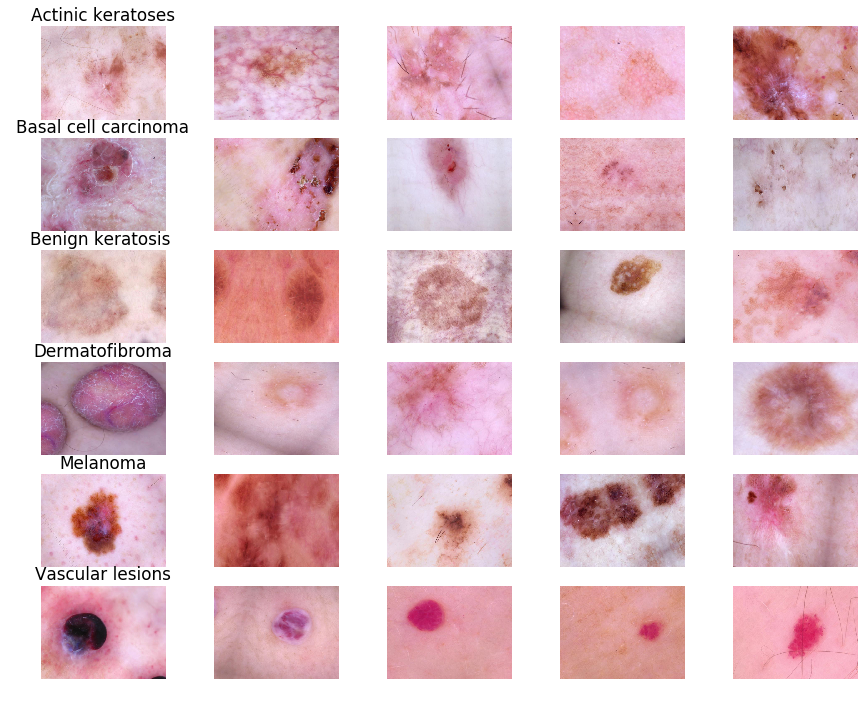

In [0]:
# prepare a df from augmented image filenames (remember we encoded the base-image-id into the augmented image filename)
df_trn_aug = pd.DataFrame(columns = df_trn.columns)
df_trn_aug['image_id'] = [x.name[:-4] for x in aug_items_trn]
df_trn_aug['path'] = aug_items_trn

for i, row in enumerate(df_trn_aug.itertuples()):
    id = row.image_id.split('_0_')[0]
    r = df_trn.loc[df_trn['image_id'] == id]
    df_trn_aug.at[i, ['label','lesion_id','lesion_type' ]] = r.label.values[0], r.lesion_id.values[0], r.lesion_type.values[0]
    
print(f'Num augmented images: {len(df_trn_aug)}')
display(df_trn_aug.head())
print(f'Examples of augmented images (nb. each row contains augmented data from different lesions)')
show_examples(df_trn_aug, 'lesion_type')

### Final training data
Merge the original and augmented datasets to give the final dataset used in training the model.

Num training images: 14972


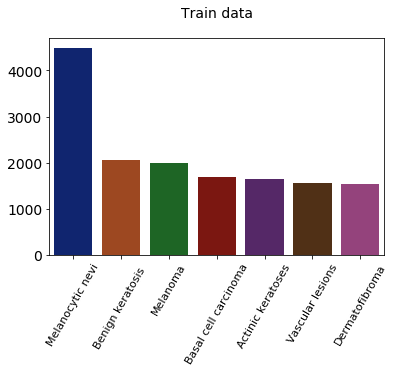

In [0]:
# merge the original and augmented image dataframes
df_trn_data = pd.concat([df_trn, df_trn_aug], ignore_index=True).set_index('image_id')
print(f'Num training images: {len(df_trn_data)}')

# Check the balance of the train and test sets
data = df_trn_data['label'].value_counts()
bar_plt(data.tolist(), [label_to_lesion[x] for x in data.keys().tolist()], title='Train data')

Though still very imbalanced, we now have more images of minority classes to use in training. 

### Parameters

In [0]:
BS = 64
IMG_SIZE = 450
INIT_SIZE = 96
NW = 4

### Create fastai DataLoader (dls) using our augmented training dataset

In [0]:
# get list of image files to pass to fastai DataSet
items_trn_data = df_trn_data.path.tolist()

In [0]:
split_idx = IndexSplitter(df_val.index)(items_trn_data)
print(f'Items train: {len(split_idx[0])}, val: {len(split_idx[1])}')

Items train: 13815, val: 1157


In [0]:
class Labeller():
    "path to label converter/decoder"
    def __init__(self, df, test=False):
        self.df = df
        
    def __call__(self, path):
        "path to label, eg. path -> label"
        p = str(path).split('/')[-1][:-4]
        return self.df.loc[p]['label']
    
    def id_to_path(self, id):
        "id to path eg.  'image_id'-> path"
        return self.df.loc[id, 'path']

In [0]:
# tfms = tuple of images and labels
tfms = [[PILImage.create], [Labeller(df_trn_data), Categorize]]

# specify item and batch level transforms (batch_tfms are executed on the GPU)
item_img_tfms = [ToTensor, FlipItem(0.5), RandomResizedCrop(INIT_SIZE, min_scale=0.35)]
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats), *aug_transforms(size=INIT_SIZE, max_rotate=30, max_warp=0.2)]

In [0]:
# create the dataset from train_img paths, images and labels and split train/val 
dsets = Datasets(items_trn_data, tfms, splits=split_idx)

In [0]:
def get_data(bs, sz):
    "return a dataloader with batch size `bs`, and image size `sz`"
    return dsets.dataloaders(bs=bs, num_workers=NW, after_item=item_img_tfms, after_batch=batch_tfms+[AffineCoordTfm(size=sz, align_corners=False)])

dls = get_data(BS, INIT_SIZE)

Num items: 13815
Key: {5: 'Melanocytic nevi', 4: 'Melanoma', 2: 'Benign keratosis ', 1: 'Basal cell carcinoma', 0: 'Actinic keratoses', 6: 'Vascular lesions', 3: 'Dermatofibroma'}


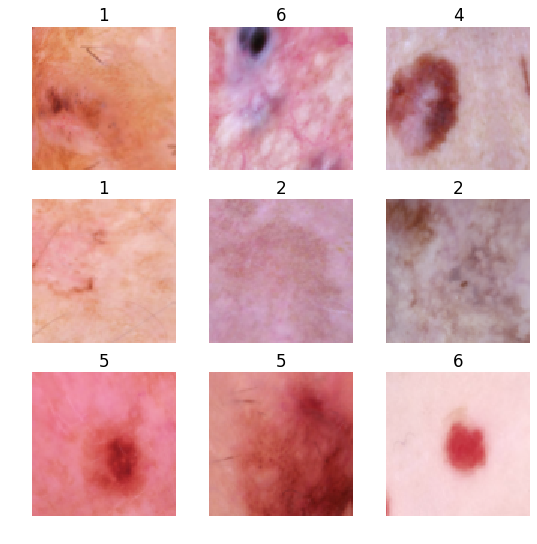

In [0]:
print(f'Num items: {len(dls.train_ds.items)}')
print(f'Key: {label_to_lesion}')
dls.show_batch(max_n=9)

### Model = densenet161

In [0]:
from torchvision.models import densenet161
model = densenet161

### Use the fastai mixup callback 
https://dev.fast.ai/callback.mixup

In [0]:
mixup = MixUp(0.4)

### Create a fastai learner

In [0]:
# get  a Learner
def get_learner():
  learn = cnn_learner(
    dls, 
    model, 
    opt_func=partial(Adam, wd=0.01, eps=1e-5), 
    cbs=mixup,
    metrics=accuracy,
    config=cnn_config(ps=0.33))
  if torch.cuda.device_count() > 1: learn.to_parallel()
  return learn.to_fp16()

learn = get_learner()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


### Select an optimal learning rate

(0.005011872202157974, 4.46683588961605e-05)

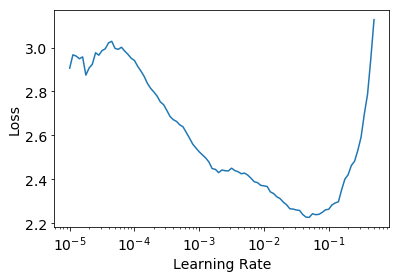

In [0]:
learn.lr_find(start_lr=1e-5, end_lr=1e-0)

### Train using progressive image resizing

epoch,train_loss,valid_loss,accuracy,time
0,1.460820,0.686711,0.774417,02:28
1,1.129863,0.622437,0.782195,02:27
2,1.041248,0.485580,0.832325,02:28
3,0.938106,0.405980,0.863440,02:25
4,0.879532,0.417760,0.853933,02:24


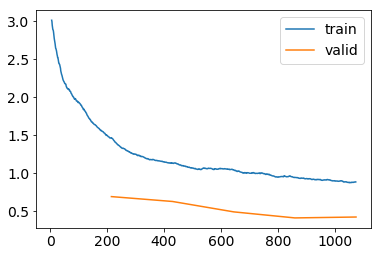

In [0]:
learn.fit_one_cycle(5, 3e-3)
learn.recorder.plot_loss()

In [0]:
learn.save('HAM10000_base')

In [0]:
assert True
RESIZE = [(5, 144, 32, 1e-3), (5, 224, 32, 1e-3), (5, 396, 16, 1e-3)]  # # (epochs, image size, batch size, learning rate)

 Training with image size: 144x144


epoch,train_loss,valid_loss,accuracy,time
0,0.951657,1.006897,0.756266,03:00
1,0.928687,0.394705,0.865169,02:56
2,0.873924,0.382630,0.870354,02:56
3,0.841003,0.324998,0.894555,02:54
4,0.796957,0.327199,0.887640,02:55


 Training with image size: 224x224


epoch,train_loss,valid_loss,accuracy,time
0,0.880331,0.380801,0.864304,03:22
1,0.870988,0.322321,0.886776,03:14
2,0.805881,0.305977,0.884183,03:14
3,0.781643,0.293687,0.885048,03:14
4,0.764710,0.278642,0.905791,03:14


 Training with image size: 396x396


epoch,train_loss,valid_loss,accuracy,time
0,0.937718,0.404279,0.844425,07:20
1,0.938317,0.401460,0.852204,07:00
2,0.886881,0.365326,0.859983,07:01
3,0.824873,0.312699,0.884183,07:00
4,0.798717,0.289289,0.900605,06:59


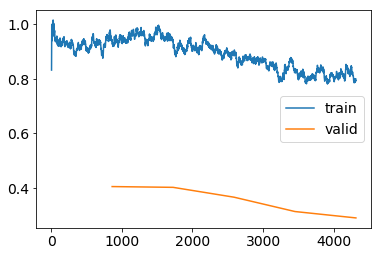

In [0]:
for params in RESIZE:
    ep, sz, bs, lr = params
    learn.dls = get_data(bs, sz)
    print(f' Training with image size: {sz}x{sz}')
    learn.fit_one_cycle(ep, lr)

learn.recorder.plot_loss()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, 1e-4, 2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.839639,0.329790,0.877269,09:55
1,0.831464,0.314359,0.885912,09:49
2,0.779616,0.288811,0.891962,09:48
3,0.748152,0.248703,0.911841,09:47
4,0.735563,0.259000,0.909248,09:46


In [0]:
learn.save('HAM10000_final')

### Test set evaluation

In [0]:
learn_eval = learn.load('HAM10000_final')

In [0]:
# get test set image paths
items_test_data = df_test.path.tolist()
print(f'Num test samples: {len(items_test_data)}')

# check to make sure no test set image paths `items_test_data` were used in training `items_train_data`
check = not set(items_test_data).isdisjoint(items_trn_data)
print(f'Test/train overlap: {check}')

Num test samples: 1448
Test/train overlap: False


In [0]:
# make predictions on test set
dl = learn.dls.test_dl(items_test_data)
preds, _, targs = learn_eval.get_preds(dl=dl, act = torch.sigmoid, with_decoded=True)
len(targs), targs[:5]

(1448, tensor([5, 5, 5, 1, 4]))

In [0]:
# get test set labels
labeller_test = Labeller(df_test)
labels = [labeller_test(i) for i in items_test_data]
len(labels), labels[:5]

(1448, [5, 5, 5, 1, 4])

In [0]:
lbls = {
 0: 'Actinic keratoses',
 1: 'Basal cell carcinoma',
 2: 'Benign keratosis ',
 3: 'Dermatofibroma',
 4: 'Melanoma',
 5: 'Melanocytic nevi',
 6: 'Vascular lesions'
 }

In [0]:
class MultiMetrics():
    "Calculate scores and metrics for model evaluation"
    def __init__(self, y, y_hat, labeldict=None, round_to=3):
        self.y = y
        self.y_hat = y_hat
        self.round_to = round_to
        self.cm = metrics.confusion_matrix(self.y, self.y_hat)
        self.labels = list(lbls.values())
        self.ave_args = ('macro', 'micro', 'weighted')
    
    def __call__(self):
        "Get individual class metrics and return with as a dataframe with text labels"
        m = metrics.precision_recall_fscore_support(self.y, self.y_hat)
        m = [[self._round(x) for x in y] for y in m]
        data = {'lesion': self.labels, 'precision': m[0], 'recall':  m[1], 'f1 score': m[2], 'support': m[3]}
        return pd.DataFrame(data)
        
    def __str__(self):
        m = metrics.classification_report(self.y, self.y_hat, digits=self.round_to)
        return m
    
    def _round(self, n): return round(n, self.round_to)
    
    @property
    def precision(self):
        return [self._round(metrics.precision_score(self.y, self.y_hat, average=x)) for x in self.ave_args]
    
    @property
    def recall(self):
        return [self._round(metrics.recall_score(self.y, self.y_hat, average=x)) for x in self.ave_args]
    
    @property
    def f1(self):
        return [self._round(metrics.f1_score(self.y, self.y_hat, average=x)) for x in self.ave_args]
    
    @property
    def kappa(self):
        return self._round(metrics.cohen_kappa_score(self.y, self.y_hat))
    
    @property
    def mclass_metrics(self):
        "Get multicalls precision, recall and f1 scores and return in a dataframe"
        data = [[p, r, f] for p, r, f in zip(self.precision, self.recall, self.f1)]
        df = pd.DataFrame(
            columns = ['precision', 'recall', 'f1 score'],
            index = self.ave_args, 
            data = data)
        df['support'] = len(self.y)
        return df
        
    @property
    def confusion_matrix(self): 
        return self.cm
    
    def plot_cm(self, title='Confusion matrix'):
        "Plot confusion matrix"
        cm_df = pd.DataFrame(columns=self.labels, index=self.labels, data=self.cm)
        fig, ax = plt.subplots(figsize=(6,4))
        sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues', linewidths=1, cbar=False)
        plt.xlabel("Predicted label", fontsize=12, fontweight='bold', labelpad=5)
        plt.ylabel("True label", fontsize=12, fontweight='bold', labelpad=5)
        plt.title(f'{title.capitalize()}\n', fontsize=16, fontweight='bold')
        plt.show

In [0]:
mm = MultiMetrics(labels, targs, labeldict=label_to_lesion, round_to=3)

In [0]:
mm()

,lesion,precision,recall,f1 score,support
0,Actinic keratoses,0.846,0.468,0.603,47
1,Basal cell carcinoma,0.917,0.698,0.793,63
2,Benign keratosis,0.603,0.843,0.704,166
3,Dermatofibroma,0.727,0.727,0.727,11
4,Melanoma,0.740,0.346,0.472,156
5,Melanocytic nevi,0.896,0.948,0.921,983
6,Vascular lesions,0.944,0.773,0.850,22


In [0]:
mm.mclass_metrics

,precision,recall,f1 score,support
macro,0.811,0.686,0.724,1448
micro,0.840,0.840,0.840,1448
weighted,0.844,0.840,0.829,1448


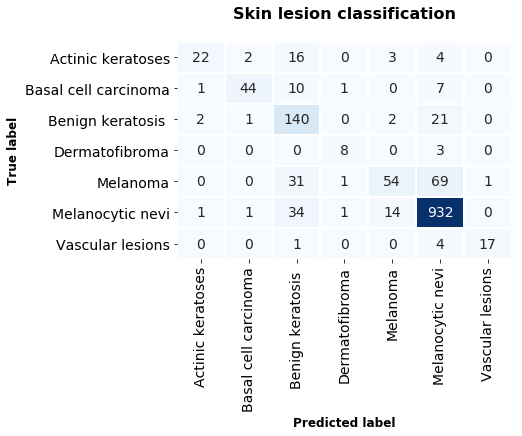

In [0]:
mm.plot_cm('Skin Lesion Classification')

In [0]:
# Cohen's kappa measures interobserver agreement with chance removed
print(f"Cohen's kappa: {mm.kappa}")

Cohen's kappa: 0.672


#### Lets look at the confidence of some of the predictions.

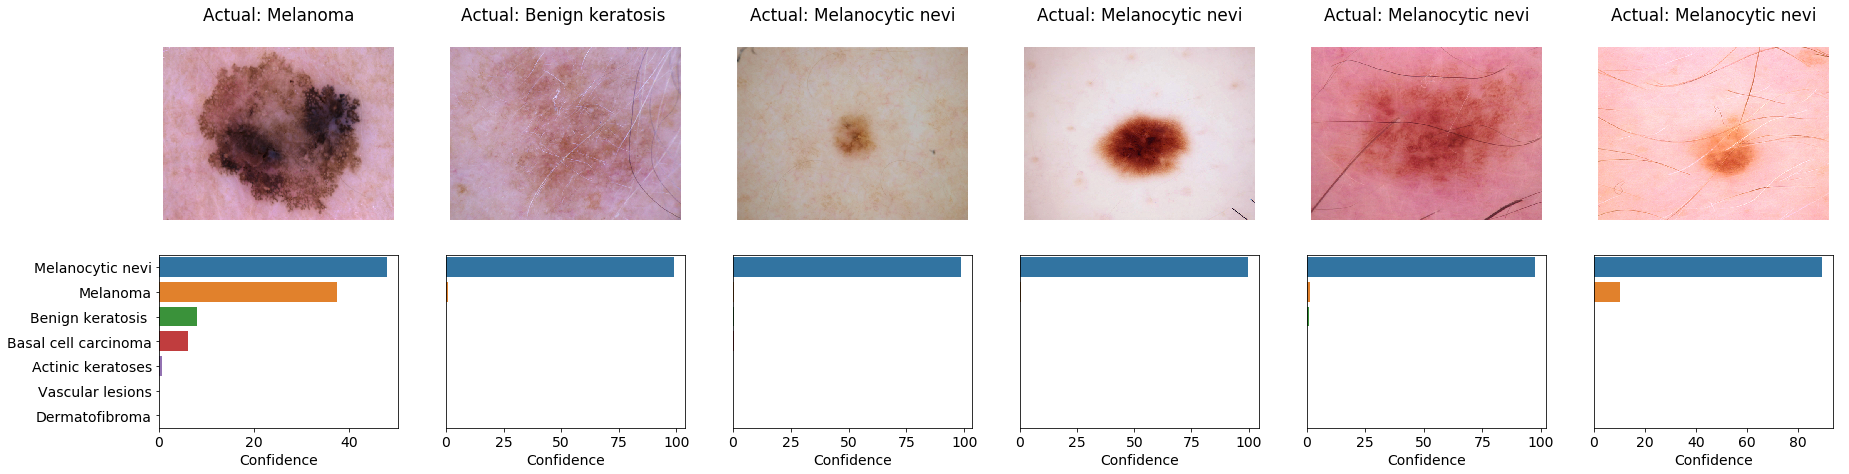

In [0]:
# show class probablities with image and label for a random selection of test set images
def item_predict(item):
    "Return class predictions and label for 'item'"
    targ, _, pred = learn_eval.predict(item)
    
    preds = pd.DataFrame(data=to_np(pred*100), columns=['Confidence'])
    preds = preds.sort_values(by='Confidence', ascending=False)
    label = labeller_test(item)
    return label, preds

def show_confidence(i, item):
        img, (o) = item
        l, p = o
        plt.subplot(2,6,i+1)
        plt.imshow(imread(img))
        plt.axis('off')
        plt.title(f'Actual: {lbls[l]}\n') 
        plt.subplot(2,6,i+7)
        sns.set_color_codes("pastel")
        sns.barplot(x=p.Confidence, y=list(label_to_lesion.values()))
        if i > 0: plt.yticks([])

        
rands = [random.randint(0, len(items_test_data)-1) for i in range(6)]
rand_items = [items_test_data[r] for r in rands]
items = [(item, item_predict(item)) for item in rand_items]

fig, axes = plt.subplots(2, 6, figsize=(30, 7))
for i, item in enumerate(items):
    show_confidence(i, item)
plt.show
pass


## References

Relevant references

1. Tschandl, P. et al. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 (2018) doi:10.1038/sdata.2018.161 
2. Aminur Rab et al. Skin Lesions Classification Using Deep Learning Based on Dilated Convolution. BioRXiv, (2019). https://www.biorxiv.org/content/10.1101/860700v2.full
3. Andre Esteva. Dermatologist-level classification of skin cancer with deep neural networks. Nature. (2017). https://www.nature.com/articles/nature21056.epdf?author_access_token=8oxIcYWf5UNrNpHsUHd2StRgN0jAjWel9jnR3ZoTv0NXpMHRAJy8Qn10ys2O4tuPakXos4UhQAFZ750CsBNMMsISFHIKinKDMKjShCpHIlYPYUHhNzkn6pSnOCt0Ftf6